In [ ]:
# default_exp classification.data

In [ ]:
# hide
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [ ]:
# hide
import warnings

from nbdev.export import *
from nbdev.showdoc import *
from timm.utils import *

warnings.filterwarnings("ignore")

setup_default_logging()

<IPython.core.display.Javascript object>

# Build
> Build a datasets and dataloaders for training

In [ ]:
# export
import logging
import pydoc
from typing import *

import pandas as pd
from fastcore.all import delegates, ifnone
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
from torch.utils.data import DataLoader, Dataset

from gale.classification.core import *
from gale.torch_utils import worker_init_fn
from gale.utils.structures import DatasetCatalog

_logger = logging.getLogger(__name__)

<IPython.core.display.Javascript object>

In [ ]:
from fastcore.all import Path
from nbdev.export import Config
from torchvision.datasets import CIFAR10

from gale.classification.core import show_image_batch
from gale.classification.augment import aug_transforms
from gale.collections.download import download_and_extract_archive

URL = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
data_path = Path(Config().path("nbs_path")) / "data"

<IPython.core.display.Javascript object>

In [ ]:
# export
@delegates(ClassificationMapper)
def register_torchvision_dataset(
    name: str,
    dataset: Dataset,
    mapper: Optional[Union[ClassificationMapper, Callable]] = None,
    **kwargs
):
    """
    Register a dataset in gale `DatasetCatalog` from a
    existing torchvision dataset. You can pass in `augmentations` to
    specify the transformations you want to apply to the Images
    in the dataset. Optionaly, `mapper` can also be passed in or else
    the default `ClassificationMapper` will be used to map the dataset in
    gale `ClassificationDataset` format.

    `name` is a `str` that identifies a dataset, e.g. "coco_2014_train".
    """
    mapper = ifnone(mapper, ClassificationMapper(**kwargs))

    DatasetCatalog.register(
        name, lambda: ClassificationDataset(mapper=mapper, parser=dataset)
    )
    _logger.info("Dataset: {} registerd to DatasetCatalog".format(name))

<IPython.core.display.Javascript object>

In [ ]:
# download the torchvision dataset
dset = CIFAR10(data_path, download=True)

# create you transforms
aug_tfms = aug_transforms(70, 64, hflip=0.5, vflip=0.5, mult=2)

# now register the dataset to gale DatasetCataLog
register_torchvision_dataset("cifar_10", dset, augmentations=aug_tfms)

Files already downloaded and verified


Dataset: cifar_10 registerd to DatasetCatalog


<IPython.core.display.Javascript object>

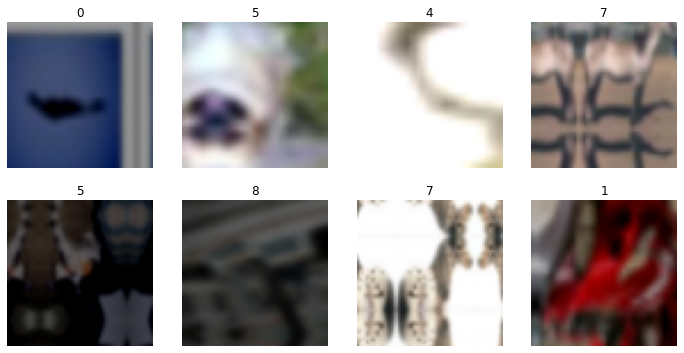

<IPython.core.display.Javascript object>

In [ ]:
ds = DatasetCatalog.get("cifar_10")

# Let's create a dataloader & view the Images
loader = DataLoader(ds, batch_size=8, shuffle=True)
show_image_batch(next(iter(loader)))

In [ ]:
# export
@delegates(ClassificationMapper)
def register_dataset_from_folders(
    name: str,
    image_root: str,
    class_map: Optional[str] = " ",
    mapper: Optional[Union[ClassificationMapper, Callable]] = None,
    **kwargs
):
    """
    Register a dataset present in folders (see `FolderParser`) to DatasetCatalog.
    `name` is a `str` that identifies a dataset, e.g. "coco_2014_train".
    """
    parser = FolderParser(root=image_root, class_map="")
    mapper = ifnone(mapper, ClassificationMapper(**kwargs))
    DatasetCatalog.register(
        name, lambda: ClassificationDataset(mapper=mapper, parser=parser)
    )
    _logger.info("Dataset: {} registerd to DatasetCatalog".format(name))

<IPython.core.display.Javascript object>

In [ ]:
# fmt:off
# download a toy dataset
download_and_extract_archive(url=URL, download_root=data_path, extract_root=data_path)

# train data is present in :
hymenoptera_data = data_path / "hymenoptera_data/train"

register_dataset_from_folders(name="hymenoptera_train_ds", image_root=hymenoptera_data, augmentations=aug_tfms)

Using downloaded and verified file: /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/gale/nbs/data


Dataset: hymenoptera_train_ds registerd to DatasetCatalog


<IPython.core.display.Javascript object>

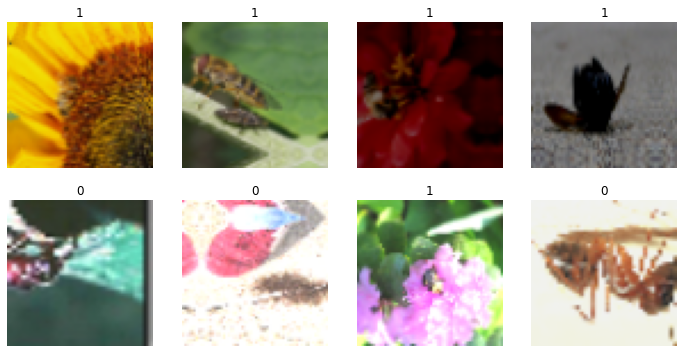

<IPython.core.display.Javascript object>

In [ ]:
ds = DatasetCatalog.get("hymenoptera_train_ds")

# Let's create a dataloader & view the Images
loader = DataLoader(ds, batch_size=8, shuffle=True)
show_image_batch(next(iter(loader)))

In [ ]:
# export
@delegates(ClassificationMapper)
def register_dataset_from_df(
    name: str,
    df: pd.DataFrame,
    path_column: str,
    label_column: str,
    class_map: Optional[str] = " ",
    mapper: Optional[Union[ClassificationMapper, Callable]] = None,
    **kwargs
):
    """
    Register a dataset present in a pandas dataframe (see `PandasParser`) to DatasetCatalog.
    `name` is a `str` that identifies a dataset, e.g. "coco_2014_train".
    """
    parser = PandasParser(df, path_column, label_column)
    mapper = ifnone(mapper, ClassificationMapper(**kwargs))
    DatasetCatalog.register(
        name, lambda: ClassificationDataset(mapper=mapper, parser=parser)
    )

    _logger.info("Dataset: {} registerd to DatasetCatalog".format(name))

<IPython.core.display.Javascript object>

In [ ]:
from gale.collections.pandas import dataframe_labels_2_int, folder2df

df = folder2df(hymenoptera_data)
df = dataframe_labels_2_int(df, label_column="target")
df.head()

Found 244 files belonging to 2 classes.


,image_id,target
0,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2638074627_6b3ae746a0.jpg,1
1,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/507288830_f46e8d4cb2.jpg,1
2,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2405441001_b06c36fa72.jpg,1
3,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/2962405283_22718d9617.jpg,1
4,/Users/ayushman/Desktop/gale/nbs/data/hymenoptera_data/train/bees/446296270_d9e8b93ecf.jpg,1


<IPython.core.display.Javascript object>

In [ ]:
register_dataset_from_df(
    name="hymenoptera_train_v0",
    df=df,
    path_column="image_id",
    label_column="target",
    augmentations=aug_tfms,
)

Dataset: hymenoptera_train_v0 registerd to DatasetCatalog


<IPython.core.display.Javascript object>

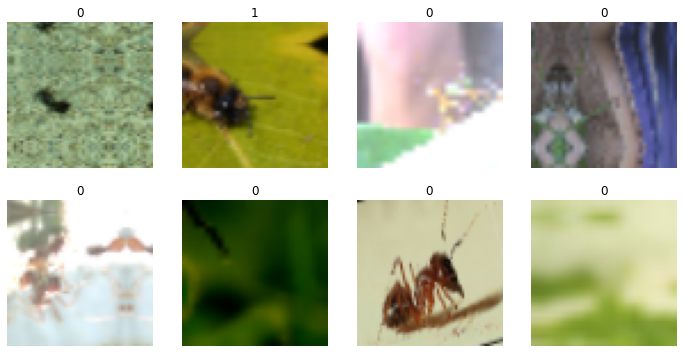

<IPython.core.display.Javascript object>

In [ ]:
ds = DatasetCatalog.get("hymenoptera_train_v0")

# Let's create a dataloader & view the Images
loader = DataLoader(ds, batch_size=8, shuffle=True)
show_image_batch(next(iter(loader)))

In [ ]:
# export
def build_classification_loader_from_config(name: str, config: DictConfig):
    """
    Build DataLoader from gale config using a dataset registerd in
    DatasetCatalog identified by `name`.

    Arguments:
    1. name (str): represents the name of the registerd dataset.
    2. config (DictConfig): gale config for a dataloader.
    """
    _logger.debug("Creating Loader for {} dataset".format(name))

    dataset = DatasetCatalog.get(name)

    _logger.debug("Found {} instances in the dataset".format(len(dataset)))

    conf = OmegaConf.to_container(config, resolve=True)

    if conf["num_workers"] > 0:
        conf["worker_init_fn"] = worker_init_fn

    if conf["sampler"] is not None:
        conf["sampler"] = instantiate(conf["sampler"])
        _logger.info("Using sampler {}".format(conf["sampler"].__class__.__name__))

    if conf["collate_fn"] is not None:
        conf["collate_fn"] = pydoc.locate(conf["collate_fn"])
        _logger.info("Using collate_fn {}".format(conf["collate_fn"]))

    loader = DataLoader(dataset, **conf)
    return loader

<IPython.core.display.Javascript object>

In [ ]:
from gale.config import get_config

cfg = get_config("classification")
cfg.datasets.train = "hymenoptera_train_v0"

<IPython.core.display.Javascript object>

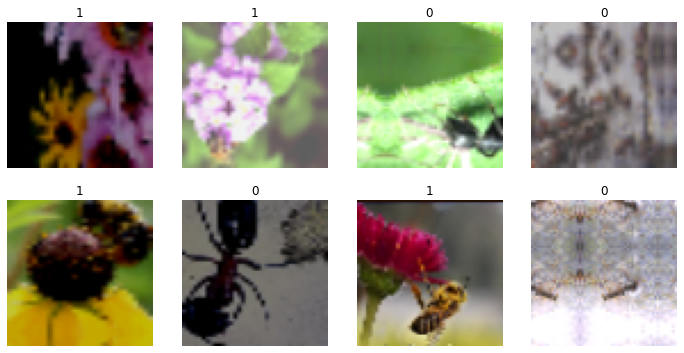

<IPython.core.display.Javascript object>

In [ ]:
dls = build_classification_loader_from_config(cfg.datasets.train, cfg.dataloader.train)

assert isinstance(dls, DataLoader)
show_image_batch(next(iter(dls)))

## Export-

In [ ]:
# hide
from nbdev.export import notebook2script

notebook2script("05b_classification.data.ipynb")

Converted 05b_classification.data.ipynb.


<IPython.core.display.Javascript object>